In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature,
convert_from_differencing,
make_multiple_predictions,
calculate_r2_scores,
apply_differencing)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
plot_multiple_predictions,
)
%load_ext skip_kernel_extension

In [2]:
import keras_tuner as kt
from scipy.signal import savgol_filter

In [3]:
config = tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)
mpl.rcParams['figure.figsize'] = [8.0, 8.0]
tf.random.set_seed(2022)

In [4]:
SKIP_RETRAIN_NN =True
SKIP_RETRAIN_RNN = True
SKIP_RETRAIN_LSTM = True
SKIP_RETRAIN_ED_LSTM = False

## Loading Data

In [5]:
bench_df = pd.read_csv("energy_dataset.csv")
bench_df = set_timestamp_index(bench_df,"time")
bench_df = bench_df['price day ahead']

In [6]:
base_df = pd.read_csv("extended_preprocessed_data.csv")
base_df = set_timestamp_index(base_df,"Unnamed: 0")

In [7]:
base_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,6378.0,25385.0,65.41,28251.0,2866.0,2866.0,1,1,0,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,5890.0,24382.0,64.92,27818.0,3436.0,6302.0,1,1,0,1
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,5461.0,22734.0,64.48,26796.0,4062.0,10364.0,1,1,0,2
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,5238.0,21286.0,59.32,25223.0,3937.0,14301.0,1,1,0,3
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,4935.0,20264.0,56.04,24620.0,4356.0,18657.0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,3113.0,30653.0,77.02,26415.0,-4238.0,-2062312.5,12,31,0,19
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,3288.0,29735.0,76.16,25213.0,-4522.0,-2066834.5,12,31,0,20
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,3503.0,28071.0,74.30,23987.0,-4084.0,-2070918.5,12,31,0,21
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,3586.0,25801.0,69.89,22748.0,-3053.0,-2073971.5,12,31,0,22


In [8]:
base_df['price actual'] = savgol_filter(base_df['price actual'],7,4)

In [9]:
resample_df = base_df.copy(deep=True)
resample_df = resample_df.resample('30min').asfreq().interpolate('cubic')
resample_df.index.inferred_freq

print(resample_df.index[0] + pd.Timedelta(resample_df.index.inferred_freq*3))

2015-01-01 01:30:00+01:00


In [10]:
diff_df = apply_differencing(resample_df,['month','day','weekend','hour'])
diff_df.index = diff_df.index.tz_convert('utc')

In [11]:
diff_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation wind onshore,total load actual,price actual,generation,energy_difference,energy_stored,month,day,weekend,hour
2014-12-31 23:30:00+00:00,0.245250,-0.286606,-0.368813,0.323198,14.612551,0.641915,-5.752631e+00,287.446012,-42.721115,-1.997218,...,-233.592903,-357.002406,0.595206,-176.312041,180.690364,1566.504310,1.0,1.0,-2.331020e-27,0.5
2015-01-01 00:00:00+00:00,-0.245250,0.286606,0.368813,-0.323198,-14.612551,1.358085,4.752631e+00,64.553988,-23.278885,-2.002782,...,-254.407097,-645.997594,-0.240748,-256.687959,389.309636,1869.495690,1.0,1.0,0.000000e+00,1.0
2015-01-01 00:30:00+00:00,-0.442500,0.536606,0.618813,-0.573198,-24.362551,0.608085,3.752631e+00,-108.196012,-50.278885,-1.252782,...,-239.657097,-807.247594,-0.881278,-403.937959,403.309636,2025.995690,1.0,1.0,2.331020e-27,1.5
2015-01-01 01:00:00+00:00,-0.346500,0.463394,0.381187,-0.426802,-14.637449,-1.608085,-8.752631e+00,-230.803988,-123.721115,0.252782,...,-189.342903,-840.752406,-1.326384,-618.062041,222.690364,2036.004310,1.0,1.0,0.000000e+00,2.0
2015-01-01 01:30:00+00:00,-0.053251,0.140181,-0.106438,-0.030405,4.837653,-4.574256,-2.875789e+01,-292.536965,-218.163345,1.883345,...,-120.653710,-768.632217,-1.611529,-827.436123,-58.803907,1952.137930,1.0,1.0,-6.993059e-27,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 20:00:00+00:00,-0.682128,-0.102528,4.613087,1.003690,20.024939,-1.664243,-3.769573e-38,-116.644257,-75.568388,-3.076761,...,99.450219,-919.411288,-1.597281,-589.321198,330.090090,-1938.305299,12.0,31.0,0.000000e+00,21.0
2018-12-31 20:30:00+00:00,-0.757376,-0.034176,1.371029,-0.165437,8.841646,0.153586,-1.256524e-38,-237.964752,-67.647796,-2.858920,...,56.066740,-1126.887096,-1.620170,-655.648733,471.238363,-1670.935100,12.0,31.0,1.242473e-13,21.5
2018-12-31 21:00:00+00:00,-0.762624,0.034176,-1.371029,-0.834563,1.158354,0.846414,1.256524e-38,-225.035248,-61.352204,-2.141080,...,26.933260,-1143.112904,-1.350674,-583.351267,559.761637,-1382.064900,12.0,31.0,0.000000e+00,22.0
2018-12-31 21:30:00+00:00,-0.632624,0.034176,-2.871029,-0.584563,-3.841646,-0.153586,1.256524e-38,-18.285248,-60.852204,-0.891080,...,22.433260,-912.112904,-0.802000,-309.351267,602.761637,-1081.314900,12.0,31.0,-1.242473e-13,22.5


# Encode- Decoder + LSTM

Scale the input data

In [12]:
scaled_df = diff_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.MinMaxScaler(feature_range=(-1,1),copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [13]:
train_start = '2015-01-01'
validation_start = '2018-11-01'
test_start = '2018-12-01'
test_end = '2018-12-19'
feature = 'price actual'
namespace= 'MS_EDLSTM_Price12'
modeltype = 'EDLSTM'
feature_df = diff_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)

Convert to (sample,timestep,feature) format

In [14]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24*14*2,24*2,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24*14*2,24*2,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24*14*2,24*2,32)


In [15]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(33216, 672, 28) (33216, 48)
(336, 672, 28) (336, 48)
(48, 672, 28) (48, 48)


Define LSTM Model

In [16]:
def build_model_ED_LSTM():
    n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
    model = models.Sequential()
    # Encoder
    model.add(layers.LSTM(64, return_sequences=True,input_shape=(None, n_features), stateful=False)) 
    model.add(layers.BatchNormalization())
    
    model.add(layers.LSTM(64, return_sequences=False, stateful=False)) 
    model.add(layers.BatchNormalization())  
    
    # Repeat Vector
    model.add(layers.RepeatVector(n_outputs))
    
    # Decoder
    model.add(layers.LSTM(64, return_sequences=True,stateful=False))
    model.add(layers.BatchNormalization())
        
    model.add(layers.LSTM(64, return_sequences=True,stateful=False))
    model.add(layers.BatchNormalization())

    # End
    model.add(layers.TimeDistributed(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal")))
    model.add(layers.TimeDistributed(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), kernel_initializer="he_normal")))
    
    model.add(layers.TimeDistributed(layers.LeakyReLU(alpha=0.2)))                     
    model.add(layers.TimeDistributed(layers.BatchNormalization()))
    model.add(layers.TimeDistributed(layers.Dense(1)))                     
                
    model.compile(optimizer='Adam',loss='mse',metrics='mae') 
    return model

In [17]:
myCheckpointLSTM= keras.callbacks.ModelCheckpoint(f"./{modeltype}/my_best_model_{namespace}.h5", save_best_only=True)
myEarly_stoppingLSTM = keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True)

In [18]:
initial_learning_rate = 0.005
num_epochs =100 
decay = initial_learning_rate/num_epochs

def scheduler(epoch,lr):
    return lr*1/(1+decay*epoch)

myLearningRate_LSTM = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)


In [19]:
liste=[1,2,3,4,5,6,7,8,9]
liste[::2]

[1, 3, 5, 7, 9]

In [20]:
batch_size = 64

In [21]:
%%skip $SKIP_RETRAIN_ED_LSTM
model_ED_LSTM= build_model_ED_LSTM()
history_ED_LSTM = model_ED_LSTM.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointLSTM,myEarly_stoppingLSTM,myLearningRate_LSTM])#

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
519/519 [==============================] - 45s 77ms/step - loss: 2.7313 - mae: 1.1440 - val_loss: 1.5965 - val_mae: 0.9137
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009999500499949514.
519/519 [==============================] - 38s 74ms/step - loss: 1.8018 - mae: 0.9182 - val_loss: 1.1529 - val_mae: 0.7638
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009998501203123563.
519/519 [==============================] - 40s 77ms/step - loss: 1.4637 - mae: 0.8282 - val_loss: 0.9039 - val_mae: 0.6804
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.000999700149540507.
519/519 [==============================] - 39s 74ms/step - loss: 1.3057 - mae: 0.7851 - val_loss: 0.8688 - val_mae: 0.6680
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.00099950026157611.
519/519 [======================

In [22]:
%%skip $SKIP_RETRAIN_ED_LSTM
histEDLSTM = pd.DataFrame(history_ED_LSTM.history)
histEDLSTM['epoch'] = history_ED_LSTM.epoch

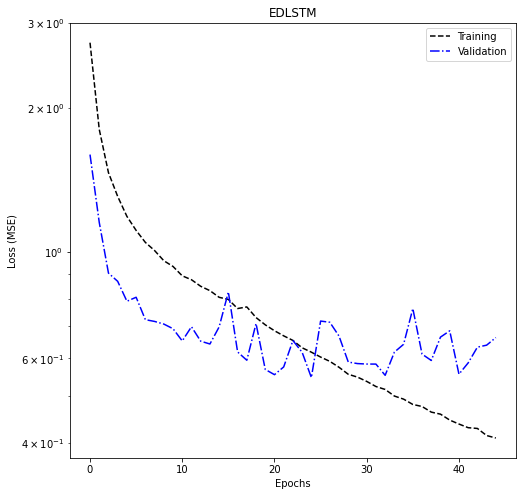

In [23]:
%%skip $SKIP_RETRAIN_ED_LSTM
fig = plot_learning_curves(histEDLSTM,modeltype,f"./{modeltype}/learningcurve_{namespace}.png")

Load best model

In [24]:
model_best_ED_LSTM = keras.models.load_model(f"./{modeltype}/my_best_model_{namespace}.h5")
model_best_ED_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          23808     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 48, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 48, 64)            33024     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 64)            2

Evaluate differencing Performance

In [26]:
i=0
case_test = data_x_val[i].reshape((1,data_x_val[0].shape[0], data_x_val[0].shape[1]))
Y_test_predictions_diff = pd.Series(model_best_ED_LSTM.predict(case_test).flatten(),index=pd.date_range(start=idx_val[i],freq='30min',periods=24*2))
y_test_filtered_diff = data_y_val0.loc[Y_test_predictions_diff.index]
y_test_filtered_diff = y_test_filtered_diff.squeeze(axis=1)

In [27]:
eval_df_diff = create_eval_df(Y_test_predictions_diff,y_test_filtered_diff)

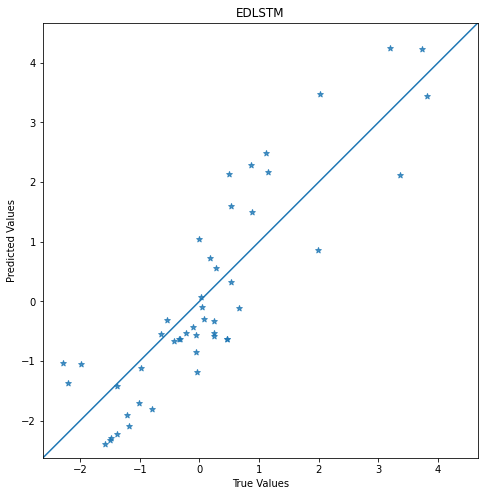

In [28]:
fig = plot_accuracy(eval_df_diff,modeltype,f"./{modeltype}/diff_accuracy_{namespace}.png")

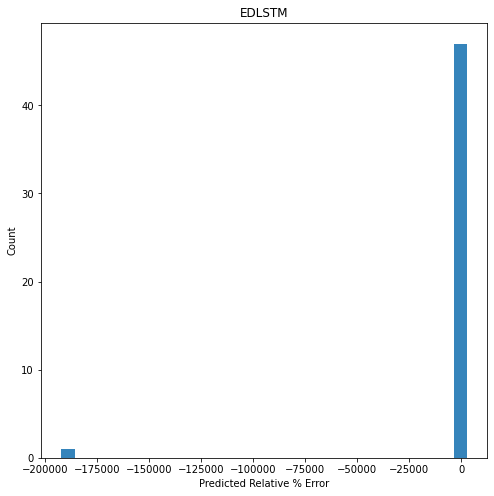

In [29]:
fig = plot_error_variations(eval_df_diff,modeltype,f"./{modeltype}/diff_error_variations_{namespace}.png")

In [30]:
abs_error_ED_LSTM = abs(Y_test_predictions_diff - y_test_filtered_diff)/y_test_filtered_diff*100
np.average(abs_error_ED_LSTM)

-4054.1193867790876

In [31]:
r2_test = r2_score(y_test_filtered_diff, Y_test_predictions_diff)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.65


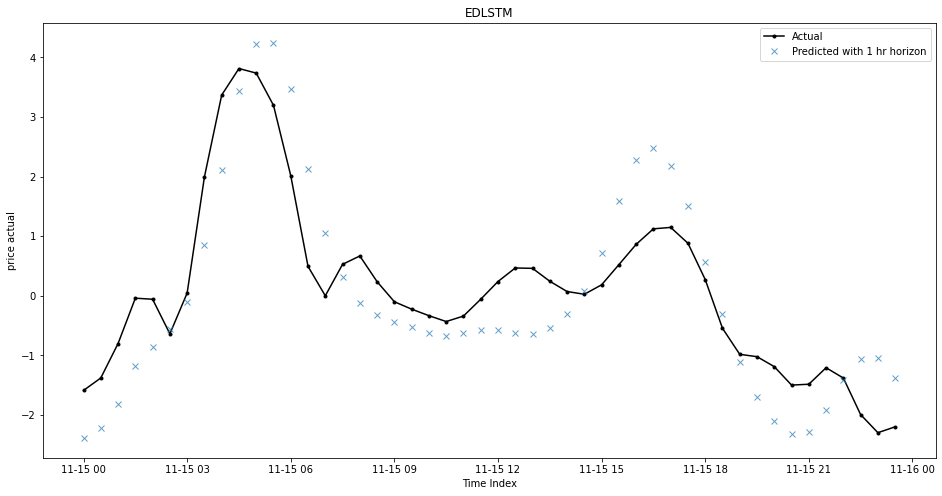

In [32]:
fig=plot_predictions(eval_df_diff,1,modeltype,feature,f"./{modeltype}/diff_predictions_{namespace}.png")

In [34]:

def make_multiple_predictions(model,idx_test,data_x_test,base_df,feature,convert=False):
    idx_prediction = pd.date_range(start=idx_test[0],freq='30min',periods=len(idx_test)+48)
    y_test_filtered = base_df.loc[idx_prediction][feature]
    df_pred =pd.DataFrame(index=y_test_filtered.index)
        
    for i in range(len(data_x_test)):
        case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
        date_range = pd.date_range(start=idx_test[i],freq='30min',periods=48)
        Y_test_predictions = pd.Series(model.predict(case_test).flatten(),index=date_range)
        if convert:
            Y_test_predictions = convert_from_differencing(Y_test_predictions,base_df,feature)
        df_pred[f'pred_{i}'] = Y_test_predictions
        
    df_pred['mean'] = df_pred.mean(axis=1)
    df_pred['Actual'] = y_test_filtered
    return df_pred

In [35]:
df_pred_diff = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,data_y_test0,feature,convert=False)

In [36]:
eval_df_diff = create_eval_df(df_pred_diff['mean'],df_pred_diff['Actual'])

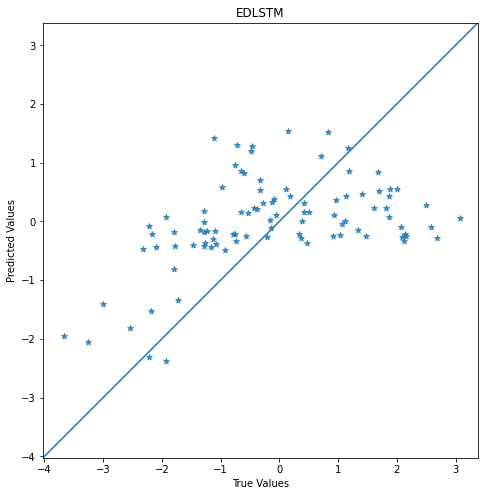

In [37]:
fig = plot_accuracy(eval_df_diff,modeltype,f"./{modeltype}/accuracy_diff_{namespace}.png")

In [38]:
# fig = plot_error_variations(eval_df_diff,modeltype,f"./{modeltype}/error_variations_diff_{namespace}.png")

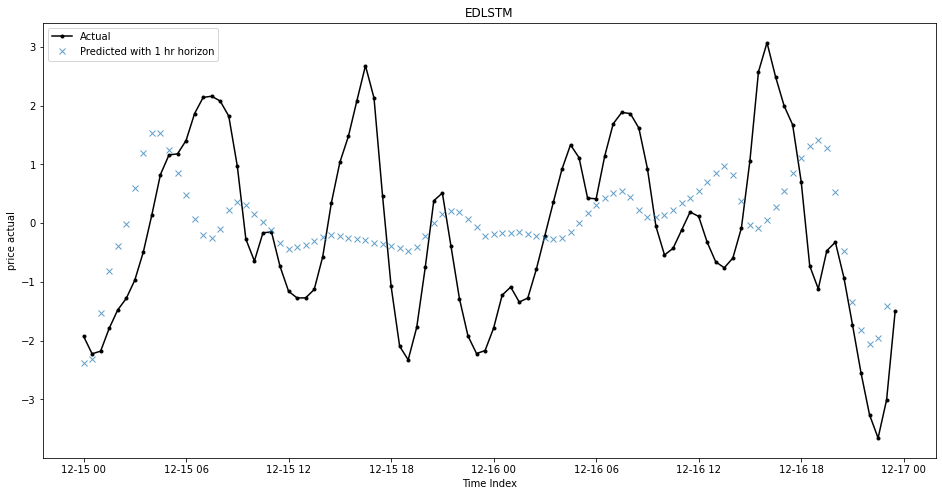

In [39]:
fig=plot_predictions(eval_df_diff,1,modeltype,feature,f"./{modeltype}/predictions_diff_{namespace}.png")

In [40]:
r2_test = r2_score(df_pred_diff['Actual'][:-1], df_pred_diff['mean'][:-1])
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.21


In [ ]:

def make_multiple_predictions(model,idx_test,data_x_test,base_df,feature,convert=False):
    idx_prediction = pd.date_range(start=idx_test[0],freq='30min',periods=len(idx_test)+48)
    y_test_filtered = base_df.loc[idx_prediction][feature]
    df_pred =pd.DataFrame(index=y_test_filtered.index)
        
    for i in range(len(data_x_test)):
        case_test = data_x_test[i].reshape((1,data_x_test[0].shape[0], data_x_test[0].shape[1]))
        date_range = pd.date_range(start=idx_test[i],freq='30min',periods=48)
        Y_test_predictions = pd.Series(model.predict(case_test).flatten(),index=date_range)
        if convert:
            Y_test_predictions = convert_from_differencing(Y_test_predictions,base_df,feature)
        df_pred[f'pred_{i}'] = Y_test_predictions
        

Reverting differencing

In [43]:
df_pred = make_multiple_predictions(model_best_ED_LSTM,idx_test,data_x_test,resample_df,feature,convert=True)

In [44]:
eval_df = create_eval_df(df_pred['mean'],df_pred['Actual'])

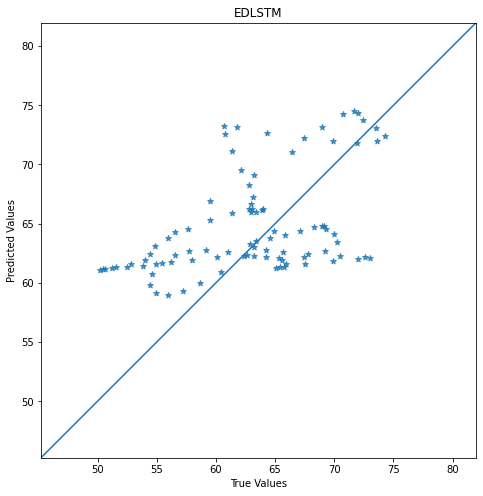

In [45]:
fig = plot_accuracy(eval_df,modeltype,f"./{modeltype}/accuracy_{namespace}.png")

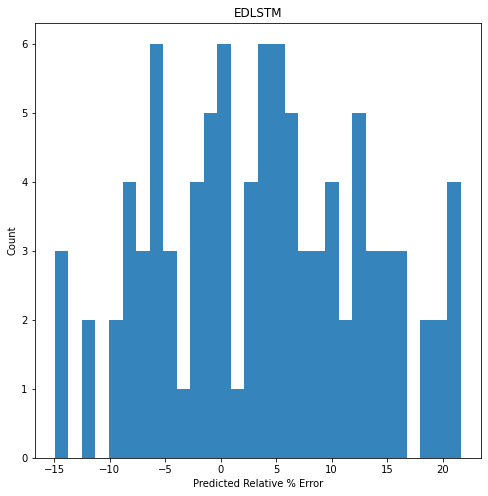

In [46]:
fig = plot_error_variations(eval_df,modeltype,f"./{modeltype}/error_variations_{namespace}.png")

In [47]:
r2_test = r2_score(df_pred['Actual'][:-1],df_pred['mean'][:-1],)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.11


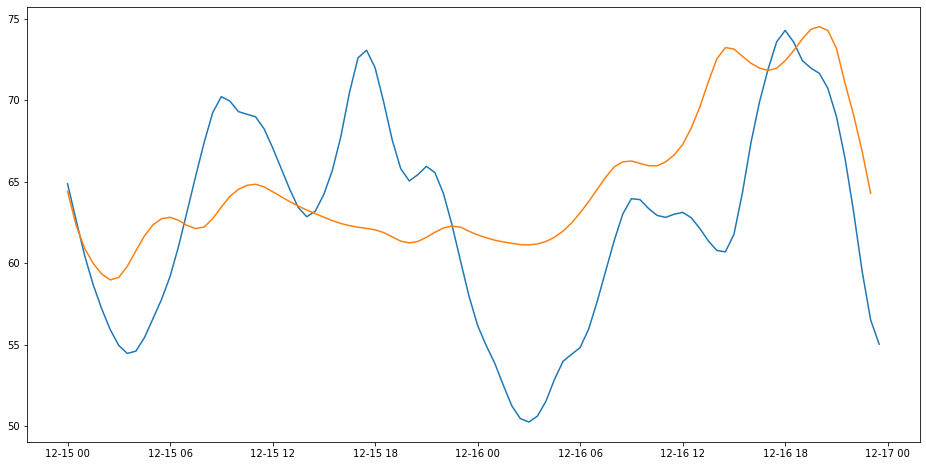

In [48]:
fig=plot_multiple_predictions(df_pred,f"./{modeltype}/multiple_predictions_bench_{namespace}.png",add_traces=False)

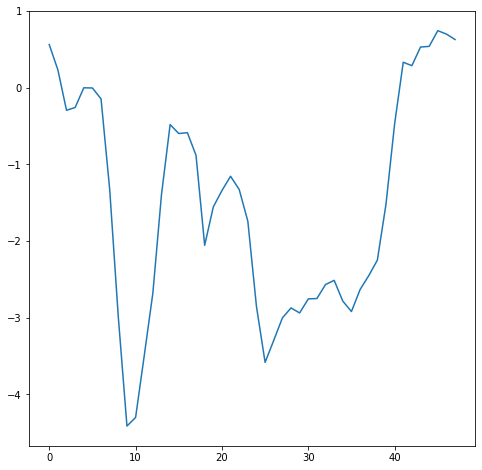

In [49]:
r2 = calculate_r2_scores(df_pred)
plt.figure()
plt.plot(r2)


Comparing to Benchmark

In [50]:
eval_df_bench = create_eval_df(bench_df[idx_val[0]:idx_val[-1]+timedelta(hours=24)],df_pred['Actual'])
eval_df_bench

ValueError: Length mismatch: Expected 192 rows, received array of length 96

In [ ]:
r2_test = r2_score(eval_df_bench['Prediction'][:-1], eval_df_bench['Actual'][:-1])
print('R^2 score is  %3.2f' %r2_test)

In [ ]:
df_pred_24h = df_pred.iloc[:,0::24]
df_pred_24h['total'] = df_pred_24h.mean(axis=1)
df_pred_24h = df_pred_24h['total'].dropna()

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(df_pred['Actual'],label = 'Actual')
plt.plot(df_pred['mean'], label= 'Prediction')
plt.plot(bench_df[idx_val[0]:idx_val[-1]+timedelta(hours=24)], label = 'Benchmark')
# plt.plot(df_pred_24h,label='only24h')
plt.legend()
plt.xlim(idx_val[0],idx_val[0]+timedelta(hours=24*14-1))

Weighted Mean

In [ ]:
df_pred_wm = df_pred.copy(deep=True)
df_pred_wm = remove_columns(df_pred_wm,['mean','Actual'])


In [ ]:
df_pred_wm = df_pred_wm.iloc[:-1,:]

In [ ]:
df_pred_wm = df_pred_wm.iloc[23:-23,:]

In [ ]:
idx = df_pred_wm.index

In [ ]:
cols = [f'pred_{x}h' for x in range(24,0,-1)]
new_df = pd.DataFrame()
liste=[]
for row in df_pred_wm.iterrows():
    a = list(row)
    new_series = list(a[1].dropna())
    liste.append(new_series)
weights = [x/24 for x in range(1,25,1)]
print(weights)
# weights = [x/sum(weights) for x in weights]
# print(weights)
new_list = []
for item in liste:
    new_list.append(np.average(item,weights=weights))
    
    
df_wp = pd.DataFrame(new_list,index=idx,columns=['Weighted Average Prediction'])

In [ ]:
fig = plt.figure(figsize=(16,8))
plt.plot(df_pred['Actual'],label = 'Actual')
plt.plot(df_pred['mean'], label= 'Prediction')
plt.plot(bench_df[idx_val[0]:idx_val[-1]+timedelta(hours=24)], label = 'Benchmark')
# plt.plot(df_wp,label='Weighted Average')
plt.legend()
